In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import pandas as pd
import time
from tqdm import tqdm
from scipy.stats import laplace as scipy_laplace
from scipy.stats import norm
from scipy.stats import qmc
import matplotlib.colors as mcolors


import multiprocessing
from multiprocessing import Pool
import concurrent.futures
import os

In [ ]:
K = 4
S_0 = 5
sigma = 0.2
r = 0.05
a = 0.15
b = 1
M = 4

L=3

L_N_l = [2000]*(L+1)
Nsim = np.sum(L_N_l)

# Randomized Quasi Monte Carlo 

## Méthode 1 : Simulation d'une séquence de N(0,1) à l'aide de l'acceptation-rejet

In [ ]:
def scrambled_sobol(N):

    """
    Simuler une séquence Sobol de lois uniformes
    """
    
    x = [((2*n-1)/(2*N) + np.random.uniform()) % 1 for n in np.arange(0.5, N+0.5, 1)]
    
    return x

In [ ]:
def simulate_exponential(lambda_):

    """
    Simulation de loi exponentielle par fonction inverse
    """

    u = np.random.random()
    
    return - m.log(u)/lambda_

In [ ]:
def simulate_s():
    
    """
    Renvoie 1 si u <= 0.5 et -1 sinon avec u une loi uniforme sur [0,1]

    """
    u = np.random.random()
    
    return 1 - 2*(u > 0.5)

In [ ]:
def simulate_laplace(n):

    """
    Simulation d'une loi de Laplace

    """
    simulations = []
    
    for i in range(n):
        y = simulate_exponential(1)
        s = simulate_s()
        simulations.append(y*s)

    return simulations

In [ ]:
def f_laplace(x):

    return 1/2 * np.exp(-abs(x))

def f_normal(x):
    
    return 1/((2*np.pi)**(1/2)) * np.exp(-x**2/2)

In [ ]:
def rejection_sampler_laplace_normal(u, M):

    x = simulate_laplace(1)[0]
    if u <= f_normal(x) / (M * f_laplace(x)):
        return x
    
    return False #on rejette ce sample

def simulate_one_sample__normal(uniforms, index, M):

    #on veut simuler une normale avec acceptation-rejet en utilisant g comme la loi de Laplace
    #on utilise les uniformes simules par Sobol
    #tant que le sample simule n'est pas accepte, on re-essaye avec le prochain uniforme de la liste des uniformes Sobol

    normal_sample = rejection_sampler_laplace_normal(uniforms[index], M)
    while not normal_sample:
        index += 1
        normal_sample = rejection_sampler_laplace_normal(uniforms[index], M)

    return normal_sample, index + 1

def simulate_normal(n, M=(2*np.exp(1)/np.pi)**(1/2)):
    
    #on commence par simuler les uniformes Sobol
    #le taux d'acceptation est 1/M
    #donc il faut simuler N*M uniformes pour que N soient acceptées
    #on multiplie ce nombre par 2 pour etre sur d'en avoir suffisament
    
    nb_uniforms = m.ceil(10*n*M)
    uniforms = scrambled_sobol(nb_uniforms)
    normal_sim = np.zeros(n)
    index = 0
    for i in range(n):
        normal_sample, index = simulate_one_sample__normal(uniforms, index, M)
        normal_sim[i] = normal_sample

    return normal_sim

In [ ]:
M_accept = (2*np.exp(1)/np.pi)**(1/2)

print(f"Taux d'acceptation = {1/M_accept}")

Taux d'acceptation = 0.7601734505331403


## Méthode 2 : Simulation d'une séquence de N(0,1) à l'aide de Box Muller

In [ ]:
def draw_2d_sobol(N):
    sampler = qmc.Sobol(d=2, scramble=True)
    power_of_2 = m.ceil(np.log2(N))
    sample = sampler.random_base2(power_of_2)
    return sample

In [ ]:
def box_muller(x):
    X = np.sqrt(-2*np.log(x[0]))*np.cos(2*np.pi*x[1])
    Y = np.sqrt(-2*np.log(x[1]))*np.cos(2*np.pi*x[0])
    return np.array([X, Y])

In [ ]:
def simulate_normal(N):
    N_sample = m.ceil(N//2)
    sample = draw_2d_sobol(N_sample)
    normals = np.apply_along_axis(box_muller, 1, sample).flatten()
    return normals[:N] #si N est pair, tout est renvoye; si N est impair, on en a simule N+1 donc on en renvoie N

## Méthode 3 : Simulation d'une séquence de N(0,1) à l'aide de la méthode d'inversion (approximation numérique)

In [ ]:
def simulate_normal(N):
    sampler = qmc.Sobol(d=1, scramble=True)
    power_of_2 = m.ceil(np.log2(N))
    sample = sampler.random_base2(power_of_2)
    normals = norm.ppf(sample)
    return normals[:N].flatten()

## Simulation des processus

In [ ]:
def sim_dW_QMC(M,L,T=1):

    """

    nombre de pas = M**L
    T: période entière (toujours égale à 1 d'après l'énoncé)


    La fonction retourne les Npas=M**L incréments du mouvement brownien

    """
    dt = T/M**L

    return (simulate_normal(M**L) *m.sqrt(dt))

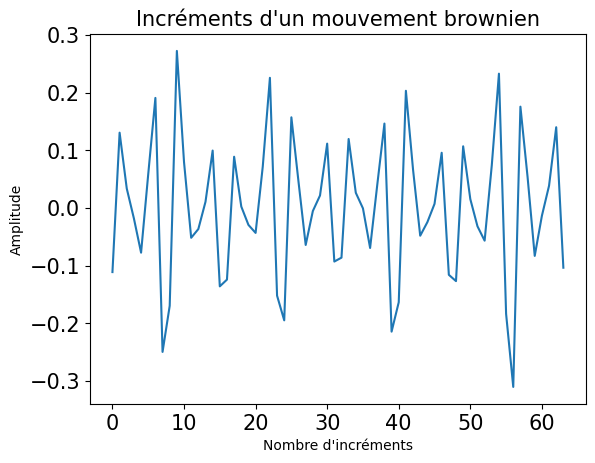

In [ ]:
dW_QMC = sim_dW_QMC(M,L,T=1)
title = "Incréments d'un mouvement brownien"
plt.xlabel("Nombre d'incréments")
plt.ylabel("Amplitude")
plt.plot(dW_QMC)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
def sim_CIR_QMC(a,b,sigma,S_0,M,L,T=1):

    """
    Simulation d'un processus CIR avec comme paramètres: a,b,sigma

    S_0 : prix de l'underlying à la date t_0 = 0
    M**L : nombre de pas
    T: période entière (toujours égale à 1 d'après l'énoncé)

    -> T/M**L = 1/M**L est le pas de discrétisation

    """
    if 2*a*b <= sigma**2:

      return("Il faut choisir des paramètres a, b et sigma adaptés")

    Npas = M**L
    S_t = [S_0]
    dt = T/Npas

    dW = sim_dW_QMC(M,L)

    for t in range(1,Npas+1):

        dS = a*(b-S_t[t-1])*dt + sigma*np.sqrt(S_t[t-1])*dW[t-1]

        S_t.append(S_t[t-1]+dS)
  
    return np.asarray(S_t)

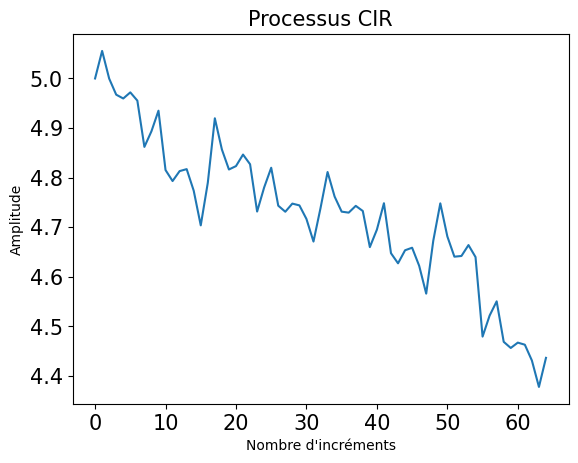

In [ ]:
CIR_QMC = sim_CIR_QMC(a,b,sigma,S_0,M,L,T=1)

plt.plot(CIR_QMC)
title = "Processus CIR"
plt.xlabel("Nombre d'incréments")
plt.ylabel("Amplitude")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
def sim_stocks_QMC(Nsim,a,b,sigma,S_0,M,L,T=1):

    Npas = M**L

    S = np.zeros(shape=(Nsim,Npas+1))

    for i in range(Nsim):

        aj = sim_CIR_QMC(a,b,sigma,S_0,M,L,T=1).T

        S[i:] = aj

    return S

In [ ]:
X = sim_stocks_QMC(Nsim,a,b,sigma,S_0,M,L,T=1)

stocks_QMC = pd.DataFrame(X)
stocks_QMC.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,5.0,5.040877,4.965433,4.939223,4.956557,4.958427,4.928049,4.860907,4.929331,5.005610,...,4.407254,4.496943,4.564275,4.496695,4.470500,4.472535,4.486086,4.464682,4.388728,4.432855
1,5.0,4.937668,4.963887,5.084272,5.063317,5.022797,5.074253,5.080894,4.972073,4.880358,...,4.517126,4.438159,4.343165,4.348909,4.395559,4.360138,4.342560,4.446133,4.470837,4.413718
2,5.0,4.953077,4.993779,4.998835,4.892466,4.834907,4.843583,4.911037,4.898835,4.874203,...,4.522904,4.500504,4.490506,4.557514,4.569870,4.518683,4.422339,4.429427,4.473142,4.433674
3,5.0,4.972804,5.010135,5.017617,4.918215,4.847765,4.866871,4.925451,4.907718,4.887455,...,4.576741,4.557959,4.545287,4.602787,4.624216,4.559293,4.457452,4.462776,4.498243,4.468754
4,5.0,4.940011,4.964199,5.001369,4.971511,4.947478,5.028244,5.023111,4.929442,4.827060,...,4.550720,4.459898,4.377690,4.371631,4.455890,4.431590,4.406303,4.439210,4.465148,4.405963


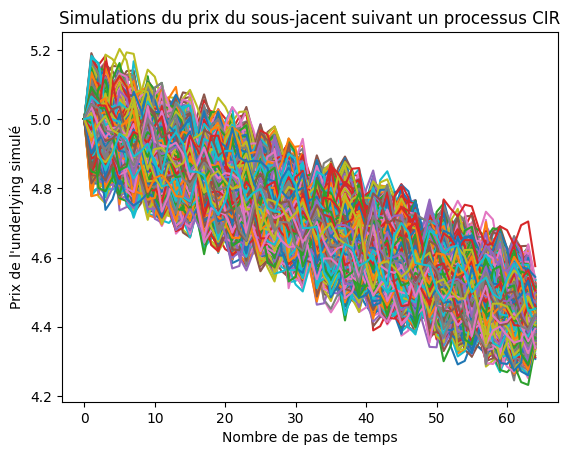

In [ ]:
plt.plot(stocks_QMC.T)
plt.title("Simulations du prix du sous-jacent suivant un processus CIR")
plt.xlabel("Nombre de pas de temps")
plt.ylabel("Prix de l'underlying simulé")
plt.show()

In [ ]:
def QMC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1):

    Lsim_stocks = sim_stocks_QMC(Nsim,a,b,sigma,S_0,M,L)
    
    prices = []
    C = []
    
    for i in range(Nsim):
        
        prices.append(Lsim_stocks[i,:].mean())
        
        C.append(max(prices[i]-K,0)*m.exp(-r*T))
        
    arithmetic_C_price  = np.mean(C)
    
    return arithmetic_C_price

In [ ]:
QMC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1)

0.6747735613819277

# Multi Level Randomized Quasi Monte Carlo (QMC MLMC)

In [ ]:
def incréments_normal_QMC(l,M):

    increments_normal_fine = simulate_normal(M**L)* m.sqrt(M**(-l))
    increments_normal_coarse = []

    i=0

    while i <= M**l-1:
      increments_normal_coarse.append(increments_normal_fine[i:i+M].sum())
      i = i+M

    return(increments_normal_fine,increments_normal_coarse)

In [ ]:
def step_simul_1(a,b,sigma,S_0,l,M):
    
    increments_normal_fine, increments_normal_coarse = incréments_normal_QMC(l,M)
  
    S_fine = [S_0]
    S_coarse = [S_0]

    dt_fine = M**(-l)
    dt_coarse = M**(-l+1)

    for i in range(1,M**l +1):
        
        dS_fine = a*(b-S_fine[i-1])*dt_fine + sigma*np.sqrt(S_fine[i-1])*increments_normal_fine[i-1]
        S_fine.append(S_fine[i-1] + dS_fine)    

        if i<= M**(l-1):    
          dS_coarse = a*(b-S_coarse[i-1])*dt_coarse + sigma*np.sqrt(S_coarse[i-1])*increments_normal_coarse[i-1]
          S_coarse.append(S_coarse[i-1] + dS_coarse)              

    return(S_fine, S_coarse)

In [ ]:
def step_simul_Nl(a,b,sigma,S_0,l,N_l,M,T=1):

    Nl_S_fine = np.zeros(shape=(N_l,M**l+1))
    Nl_S_coarse = np.zeros(shape=(N_l,M**(l-1)+1))

    for i in range(N_l):

        aj = step_simul_1(a,b,sigma,S_0,l,M)

        Nl_S_fine[i:] = np.array(aj[0]).T
        Nl_S_coarse[i:] = np.array(aj[1]).T

    
    return(Nl_S_fine,Nl_S_coarse)

In [ ]:
def liste_payoff(a,b,sigma,S_0,l,N_l,M,K,r,T=1):

    if l == 0:
      _, Nl_S_fine = step_simul_Nl(a,b,sigma,S_0,l+1,N_l,M,T=1)
      Mean_fine = Nl_S_fine.mean(axis=1)
      payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T) 
      return(payoff_fine,np.zeros(N_l))

    Nl_S_fine, Nl_S_coarse = step_simul_Nl(a,b,sigma,S_0,l,N_l,M,T=1)
    Mean_fine = Nl_S_fine.mean(axis=1)
    Mean_coarse =  Nl_S_coarse.mean(axis=1)
    
    # Calculer les payoffs pour les deux niveaux L et L-1

    payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T)   
    payoff_coarse = np.maximum(Mean_coarse - K , 0)* m.exp(-r*T) 
   
    return (payoff_fine,payoff_coarse)

In [ ]:
def estimateur_Yl(a,b,sigma,S_0,l,N_l,M,K,r,T=1):
    
    payoff_fine, payoff_coarse = liste_payoff(a,b,sigma,S_0,l,N_l,M,K,r,T=1)
    
    diff = payoff_fine - payoff_coarse

    result_l = diff.mean()

    variance_l = np.var(diff)

    return(result_l,variance_l, payoff_fine, payoff_coarse)

In [ ]:
def QMC_MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1):
  
  """
  L_N_l est la liste qui contient N_l pour chaque l

  """
  C = 0 
  V_l = []
  for l in range(0,L+1):
    
    X = estimateur_Yl(a,b,sigma,S_0,l,L_N_l[l],M,K,r,T=1)
    C = C + X[0]
    V_l.append(X[1])

  return(C,V_l)

In [ ]:
QMC_MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1)

(0.6721181612040389,
 [0.00601624111283563,
  0.004687951159018739,
  8.089933532693328e-05,
  1.323087756426358e-06])

# Comparaison de la CPU time et de la variance entre QMC et QMC MLMC avec paramètres non optimaux

In [ ]:
def variance_cpu_mc__process(args):
    Nsim,a,b,sigma,S_0,r,K,M,L,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    C_approx = QMC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    stop = time.time()
    return C_approx, stop-start

def variance_cpu_qmc(n_estimators, Nsim,a,b,sigma,S_0,r,K,M,L,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(Nsim,a,b,sigma,S_0,r,K,M,L,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mc__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = Y_hat
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
def variance_cpu_mlmc__process(args):
    a,b,sigma,S_0,L_N_l,M,K,r,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    C_approx, _ = QMC_MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1)
    stop = time.time()
    return C_approx, stop-start

def variance_cpu_qmc_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(a,b,sigma,S_0,L_N_l,M,K,r,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mlmc__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = Y_hat
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
n_estimators = 10

In [ ]:
var_qmc, mean_C_qmc, mean_cpu_qmc, _ = variance_cpu_qmc(n_estimators, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)

In [ ]:
var_qmc_mlmc, mean_C_qmc_mlmc, mean_cpu_qmc_mlmc, _ = variance_cpu_qmc_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1)

In [ ]:
print(f"Estimation QMC = {mean_C_qmc} // Estimation QMC_MLMC = {mean_C_qmc_mlmc}")
print(f"Variance QMC = {var_qmc} // Variance QMC_MLMC = {var_qmc_mlmc}")
print(f"Temps moyen d'execution QMC = {round(mean_cpu_qmc, 3)}s // Temps moyen d'execution QMC_MLMC = {round(mean_cpu_qmc_mlmc, 3)}s")

Estimation QMC = 0.67570447486702 // Estimation QMC_MLMC = 0.6799088032821411
Variance QMC = 4.529104988899518e-07 // Variance QMC_MLMC = 4.975009079443691e-05
Temps moyen d'execution QMC = 13.411s // Temps moyen d'execution QMC_MLMC = 9.666s


# Optimisation des paramètres $L$ et $N_L$ de QMC MLMC

In [ ]:
def liste_payoff(a,b,sigma,S_0,l,N_l,M,K,r,T=1):

    if l == 0:
      _, Nl_S_fine = step_simul_Nl(a,b,sigma,S_0,l+1,N_l,M,T=1)
      Mean_fine = Nl_S_fine.mean(axis=1)
      payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T) 
      return(payoff_fine,np.zeros(N_l))

    Nl_S_fine, Nl_S_coarse = step_simul_Nl(a,b,sigma,S_0,l,N_l,M,T=1)
    Mean_fine = Nl_S_fine.mean(axis=1)
    Mean_coarse =  Nl_S_coarse.mean(axis=1)
    
    # Calculer les payoffs pour les deux niveaux L et L-1

    payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T)   
    payoff_coarse = np.maximum(Mean_coarse - K , 0)* m.exp(-r*T) 
   
    return (payoff_fine,payoff_coarse)

In [ ]:
def re_estimateur_Yl(prev_payoff_fine, prev_payoff_coarse, a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1):
    
    payoff_fine, payoff_coarse = liste_payoff(a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1)

    payoff_fine = np.append(prev_payoff_fine, payoff_fine)
    payoff_coarse = np.append(prev_payoff_coarse, payoff_coarse)
    
    diff = payoff_fine - payoff_coarse

    result_l = diff.mean()

    variance_l = np.var(diff)

    return(result_l,variance_l, payoff_fine, payoff_coarse)

In [ ]:
def qmc_mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1):
  ## step 1 ##
    L = 0

    Nl = []
    Vl = []
    payoffs = []
    Y_hat = []

    while True:
        ## step 2 ## 
        NL = int(1e4)
        Y_hat_L, V_L, payoff_fine_L, payoff_coarse_L = estimateur_Yl(a,b,sigma,S_0,L,NL,M,K,r,T=1)

        V_L = np.sum(V_L)
        Y_hat.append(Y_hat_L)
        Vl.append(V_L)
        payoffs.append([payoff_fine_L, payoff_coarse_L])

        ## step 3 ##
        sum_variances = 0
        for l in range(L+1):
            h_l = M**(-l)
            sum_variances += np.sqrt(Vl[l]/h_l)

        error_term = 2 * eps**(-2)
        Nl = [m.ceil(error_term * np.sqrt(Vl[l] * M**(-l)) * sum_variances) for l in range(L+1)]

        ## step 4 ##

        for l in range(L+1):
            if Nl[l] > len(payoffs[l][0]): #il faut reevaluer Yl avec plus de samples
                nb_extra_samples = Nl[l] - len(payoffs[l][0])
                Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = re_estimateur_Yl(payoffs[l][0], payoffs[l][1], a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1)
                Y_hat[l] = Y_hat_l
                Vl[l] = V_l
                payoffs[l] = [payoff_fine_l, payoff_coarse_l]
            elif Nl[l] == len(payoffs[l][0]):
                pass # on a le bon nombre de samples
            else:
                #Nl[l] < len(payoffs[l][0]) donc on a trop de samples dans les payoffs
                Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = estimateur_Yl(a,b,sigma,S_0,l,Nl[l],M,K,r,T=1)
                Y_hat[l] = Y_hat_l
                Vl[l] = V_l
                payoffs[l] = [payoff_fine_l, payoff_coarse_l]

        #extra_samples(L, Nl, Y_hat, Vl, payoffs)

        ## step 5 ##
        if L >= 2:
            #on teste la convergence, avec equation 11
            diff_estimateurs = abs(Y_hat[-1] - M**(-1) * Y_hat[-2])
            tolerance = 1/np.sqrt(2) * (M**2 - 1)*eps
            if diff_estimateurs < tolerance:
                return Y_hat, Vl, Nl

        ## step 6 ##
        L += 1

# Comparaison de la CPU time et de la variance entre QMC, QMC MLMC avec paramètres non optimaux et QMC MLMC avec paramètres adaptés (optimisés)

In [ ]:
def variance_cpu_mlmc_adaptative__process(args):
    eps,a,b,sigma,S_0,M,K,r,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    Y_hat, _, _= qmc_mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1)
    stop = time.time()

    return Y_hat, stop-start

def variance_cpu_qmc_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(eps,a,b,sigma,S_0,M,K,r,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mlmc_adaptative__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = np.sum(Y_hat)
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
def comparaison_variance(n_estimators, N_sim_mc, L_N_l, eps, a,b,sigma,S_0,r,K,M,L,T=1, show=True, show_pbar=False):
    if show_pbar:
        with tqdm(total=3) as pbar:
            var_mc, mean_C_mc, mean_cpu_mc, _ = variance_cpu_qmc(n_estimators, N_sim_mc,a,b,sigma,S_0,r,K,M,L,T=1)
            pbar.update(1)
            var_mlmc, mean_C_mlmc, mean_cpu_mlmc, _ = variance_cpu_qmc_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1)
            pbar.update(1)
            var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad, _ = variance_cpu_qmc_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1)
            pbar.update(1)
    else:
        var_mc, mean_C_mc, mean_cpu_mc, _ = variance_cpu_qmc(n_estimators, N_sim_mc,a,b,sigma,S_0,r,K,M,L,T=1)
        var_mlmc, mean_C_mlmc, mean_cpu_mlmc, _ = variance_cpu_qmc_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1)
        var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad, _ = variance_cpu_qmc_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1)

    if show:
        print()
        print(f"   QMC ({N_sim_mc} sim)    --> Estimation = {mean_C_mc} // Variance = {var_mlmc_ad} // CPU moyen = {round(mean_cpu_mc, 3)}s")
        print(f"   QMC_MLMC (Nl={L_N_l})   --> Estimation = {mean_C_mlmc} // Variance = {var_mlmc} // CPU moyen = {round(mean_cpu_mlmc, 3)}s")
        print(f"QMC_MLMC_adpt (eps= {eps}) --> Estimation = {mean_C_mlmc_ad} // Variance = {var_mc} // CPU moyen = {round(mean_cpu_mlmc_ad, 3)}s")
    
    return var_mlmc_ad, mean_C_mc, mean_cpu_mc, var_mlmc, mean_C_mlmc, mean_cpu_mlmc, var_mc, mean_C_mlmc_ad, mean_cpu_mlmc_ad

In [ ]:
n_estimators = 30
L = 3
L_N_l = [2000]*(L+1)
N_sim_mc = np.sum(L_N_l)
eps = 1e-3

In [ ]:
x = comparaison_variance(n_estimators, N_sim_mc, L_N_l, eps, a,b,sigma,S_0,r,K,M,L,T=1, show_pbar=True)

100%|██████████| 3/3 [05:40<00:00, 113.64s/it]


   QMC (8000 sim)    --> Estimation = 0.6756918370604154 // Variance = 3.8903824617563354e-07 // CPU moyen = 8.542s
   QMC_MLMC (Nl=[2000, 2000, 2000, 2000])   --> Estimation = 0.6810696344946053 // Variance = 3.691308905418361e-05 // CPU moyen = 6.472s
QMC_MLMC_adpt (eps= 0.001) --> Estimation = 0.6789191728473984 // Variance = 4.969501916501594e-07 // CPU moyen = 297.095s


# Variation des paramètres 

## Variation de M 

In [ ]:
eps_var_M = 1e-3
n_estimators_var_M = 30
N_sim_mc_var_M = 8000
L_N_l_var_M = [2000]*4
M_loops = range(2, 8)

variances = []
full_cpu_times = []
cpu_times = []

for i in tqdm(range(len(M_loops))):
    M_loop = M_loops[i]
    start = time.time()
    var_mc, mean_C_mc, mean_cpu_mc, var_mlmc, mean_C_mlmc, mean_cpu_mlmc, var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad = comparaison_variance(n_estimators_var_M, 
                                                                                                                                               N_sim_mc_var_M,
                                                                                                                                               L_N_l_var_M, 
                                                                                                                                               eps_var_M, 
                                                                                                                                               a,b,sigma,S_0,r,K,M,L,T=1, show=False)
    stop = time.time()

    full_cpu_times.append(stop-start)
    variances.append([var_mc, var_mlmc, var_mlmc_ad])
    cpu_times.append([mean_cpu_mc, mean_cpu_mlmc, mean_cpu_mlmc_ad])

100%|██████████| 6/6 [30:53<00:00, 308.92s/it]


In [ ]:
var_mc = [variance[0] for variance in variances]
var_mlmc = [variance[1] for variance in variances]
var_mlmc_ad = [variance[2] for variance in variances]

cpu_mc = [cpu_time[0] for cpu_time in cpu_times]
cpu_mlmc = [cpu_time[1] for cpu_time in cpu_times]
cpu_mlmc_ad = [cpu_time[2] for cpu_time in cpu_times]

variance_per_method = [var_mc, var_mlmc, var_mlmc_ad]
cpu_per_method = [cpu_mc, cpu_mlmc, cpu_mlmc_ad]
names = ['MC', 'MLMC', 'MLMC Adpt']

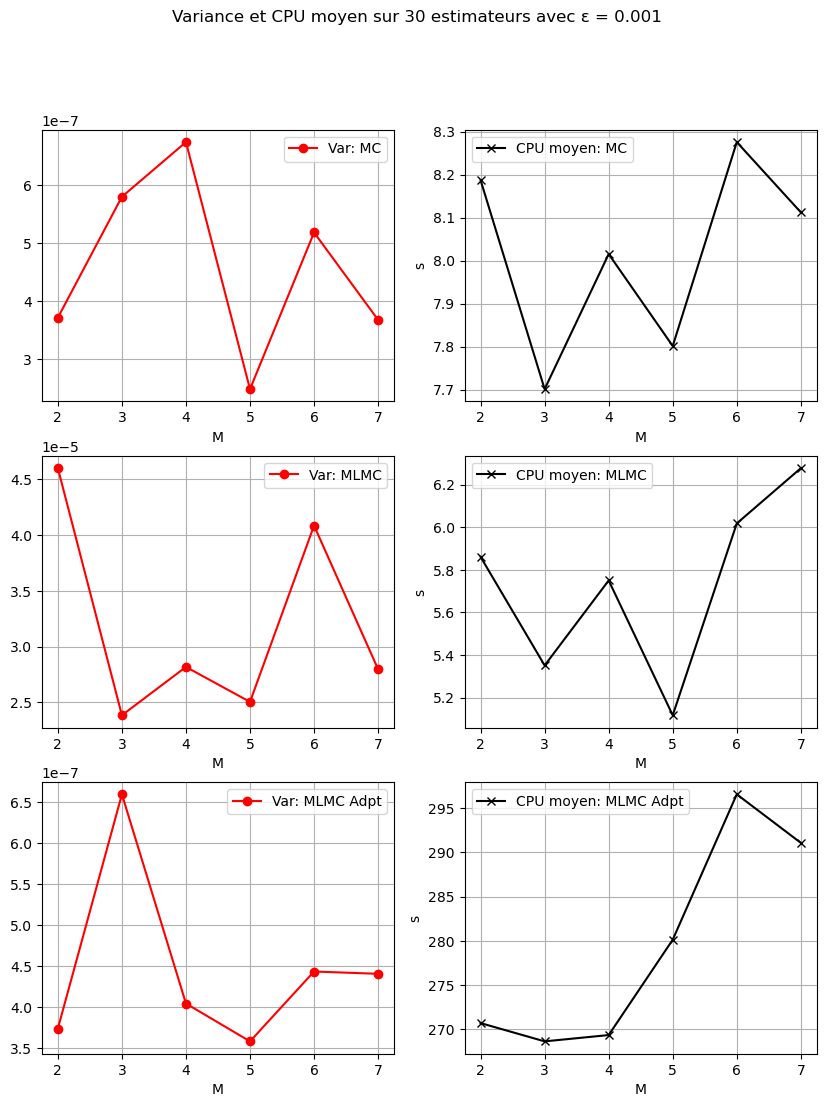

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i, ax in enumerate(axs):
    ax[0].plot(M_loops, variance_per_method[i], c = 'r', label = f'Var: {names[i]}', marker='o')
    ax[0].legend(loc='best')
    ax[0].grid('on')
    ax[0].set_xlabel('M')

    ax[1].plot(M_loops, cpu_per_method[i], c = 'black', label = f'CPU moyen: {names[i]}', marker='x')
    ax[1].legend(loc='best')
    ax[1].grid('on')
    ax[1].set_xlabel('M')
    ax[1].set_ylabel('s')

plt.suptitle(f'Variance et CPU moyen sur {n_estimators_var_M} estimateurs avec ε = {eps_var_M}')
plt.show()

## Variation de epsilon

In [ ]:
times_eps = []
Nls_eps = []
Y_hat_eps = []
Vl_eps = []
epsilons = np.linspace(1e-1, 3e-4, 30)
for i in tqdm(range(len(epsilons))):
    eps = epsilons[i]
    start = time.time()
    Y_hat, Vl, Nl = qmc_mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1)
    stop = time.time()
    times_eps.append(stop-start)
    Nls_eps.append(Nl)
    Y_hat_eps.append(Y_hat)
    Vl_eps.append(Vl)

100%|██████████| 30/30 [4:24:29<00:00, 528.99s/it] 


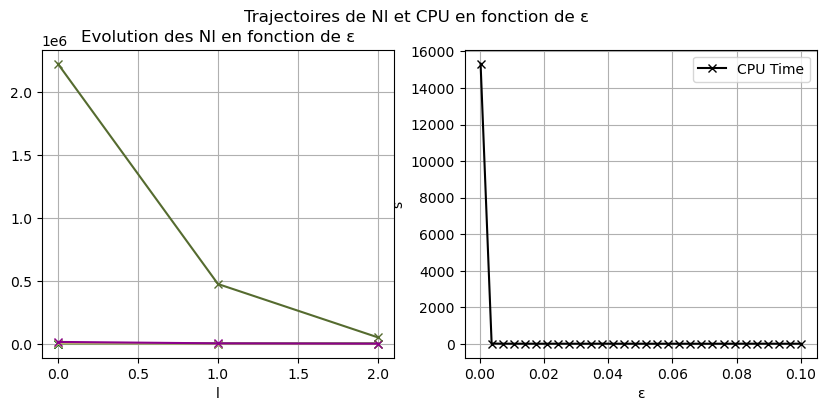

In [ ]:
markers = ["x", "o", "*", "+", "v", ">", "<"]
colors = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, Nl in enumerate(Nls_eps):
    ax[0].plot(Nl, color = colors[i], marker = "x", label = f"ε={epsilons[i]}")
ax[0].grid('on')
#ax[0].legend(loc='best')
ax[0].set_xlabel("l")
ax[0].set_title("Evolution des Nl en fonction de ε")

ax[1].plot(epsilons[:len(times_eps)], times_eps, c = 'black', label = 'CPU Time', marker='x')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('ε')
ax[1].set_ylabel('s')

plt.suptitle(f'Trajectoires de Nl et CPU en fonction de ε')
plt.show()

#### Graphes plus adaptés

In [ ]:
dic_eps = dict()
for i in range(len(times_eps)):
    dic_eps[epsilons[i]] = (Nls_eps[i], times_eps[i])

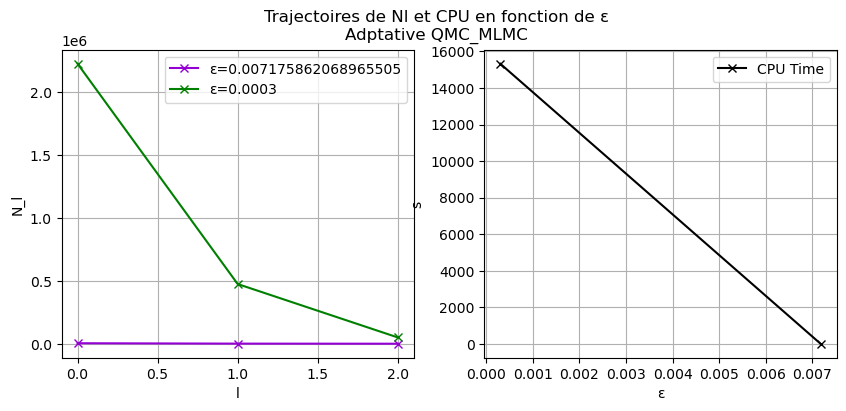

In [ ]:
colors = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

indices = [27, 29]

for i in indices:
    Nl = Nls_eps[i]
    color = np.random.choice(colors)
    ax[0].plot(Nl, color = color, marker = "x", label = f"ε={epsilons[i]}")
ax[0].grid('on')
ax[0].legend(loc='best')
ax[0].set_xlabel("l")
ax[0].set_ylabel('N_l')
#ax[0].set_title("Evolution des Nl en fonction de ε")

ax[1].plot([epsilons[i] for i in indices], [times_eps[i] for i in indices], c = 'black', label = 'CPU Time', marker='x')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('ε')
ax[1].set_ylabel('s')

plt.suptitle(f'Trajectoires de Nl et CPU en fonction de ε\nAdptative QMC_MLMC\n')
plt.show()

# MSE

In [ ]:
true_C = 0.6797012714083033 # Cette valeur est trouvé par Monte Carlo standard avec N_sim très grand comme expliqué dans le rapport 

#### MSE de QMC en fonction de Nsim

In [ ]:
n_approx = 30
Nsim_loop = range(1000, 15000+100, 100)
MSE_QMC = []
variances_QMC_Nsim = []
mean_cpu_QMC_Nsim = []

for i in tqdm(range(len(Nsim_loop))):
    Nsim = Nsim_loop[i]
    variance, mean_C_estimated, mean_cpu_time, estimators = variance_cpu_qmc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse = np.mean([(x-true_C)**2 for x in estimators])
    MSE_QMC.append(Mse)
    variances_QMC_Nsim.append(variance)
    mean_cpu_QMC_Nsim.append(mean_cpu_time)

100%|██████████| 141/141 [28:16<00:00, 12.03s/it]


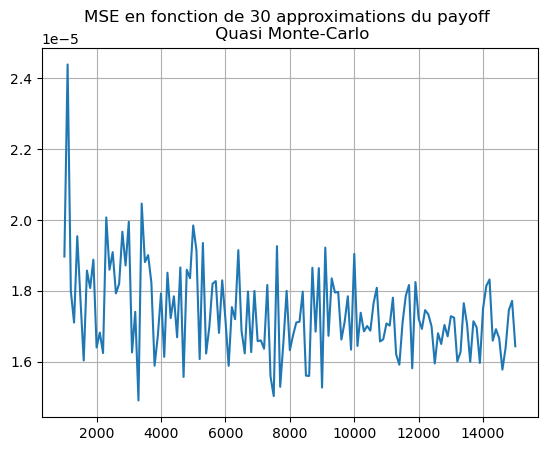

In [ ]:
plt.plot(Nsim_loop[:len(MSE_QMC)], MSE_QMC)
plt.title(f'MSE en fonction de {n_approx} approximations du payoff \n Quasi Monte-Carlo')
plt.grid('on')
plt.show()

#### MSE de QMC_MLMC en fonction de epsilon

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [ ]:
def draw_graph(eps_loop, MSE_QMC_MLMC):
    pl.clf()
    pl.plot(eps_loop[:len(MSE_QMC_MLMC)], MSE_QMC_MLMC)
    pl.grid('on')
    pl.xlabel('ε')
    pl.ylabel('MSE')
    pl.title('MSE en fonction de la tolérance d\'erreur \n Adaptative QMC_MLMC')
    display.display(pl.gcf())
    display.clear_output(wait=True)

In [ ]:
n_approx = 30
eps_loop = np.linspace(1e-1, 3e-4, 100)
MSE_QMC_MLMC_eps = []
var_QMC_MLMC_eps = []
cpu_QMC_MLMC_eps = []

for i in range(len(eps_loop)):
    eps = eps_loop[i]
    variance, mean_C_estimated, mean_cpu_time, estimators = variance_cpu_qmc_mlmc_adaptative(n_approx, eps,a,b,sigma,S_0,M,K,r,T=1)
    Mse = np.mean([(x-true_C)**2 for x in estimators])
    MSE_QMC_MLMC_eps.append(Mse)
    var_QMC_MLMC_eps.append(variance)
    cpu_QMC_MLMC_eps.append(mean_cpu_time)
    draw_graph(eps_loop, MSE_QMC_MLMC_eps)

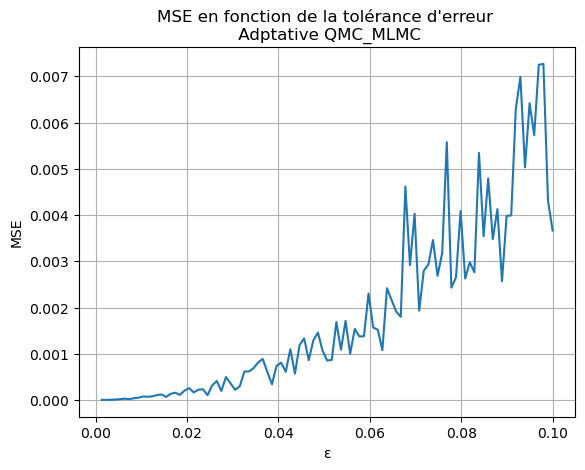

In [ ]:
plt.plot(eps_loop[:len(MSE_QMC_MLMC_eps)], MSE_QMC_MLMC_eps)
plt.title('MSE en fonction de la tolérance d\'erreur \n Adptative QMC_MLMC')
plt.grid('on')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.show()

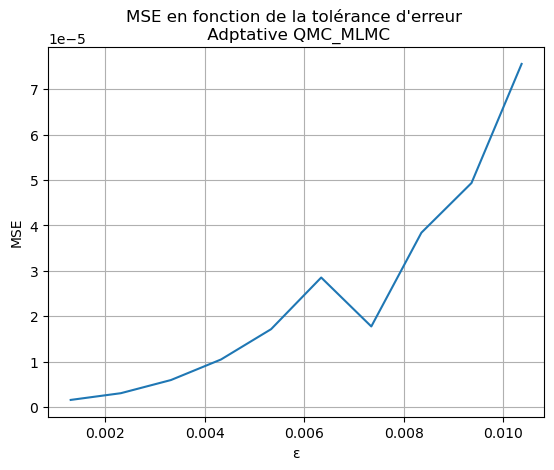

In [ ]:
plt.plot(eps_loop[len(MSE_QMC_MLMC_eps)-10:len(MSE_QMC_MLMC_eps)], MSE_QMC_MLMC_eps[len(MSE_QMC_MLMC_eps)-10:])
plt.title('MSE en fonction de la tolérance d\'erreur \n Adptative QMC_MLMC')
plt.grid('on')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.show()

# Comparaison MSE/Variance/CPU entre QMC et QMC_MLMC

In [ ]:
n_approx = 30
Nsim_loop_cmp = range(1000, 20000+100, 100)

MSE_QMC_cmp = []
MSE_QMC_MLMC_cmp = []

variances_QMC_Nsim_cmp = []
mean_cpu_QMC_Nsim_cmp = []

variances_QMC_MLMC_Nsim_cmp = []
mean_cpu_QMC_MLMC_Nsim_cmp = []

for i in tqdm(range(len(Nsim_loop_cmp))):
    Nsim = Nsim_loop_cmp[i]
    
    variance_qmc, mean_C_estimated_qmc, mean_cpu_time_qmc, estimators_qmc = variance_cpu_qmc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse_qmc = np.mean([(x-true_C)**2 for x in estimators_qmc])
    MSE_QMC_cmp.append(Mse_qmc)
    variances_QMC_Nsim_cmp.append(variance_qmc)
    mean_cpu_QMC_Nsim_cmp.append(mean_cpu_time_qmc)
    
    L = 3
    L_N_l_loop_cmp = [m.ceil(Nsim/(L+1)) for _ in range(L+1)]
    variance_qmc_mlmc, mean_C_estimated_qmc_mlmc, mean_cpu_time_qmc_mlmc, estimators_qmc_mlmc = variance_cpu_qmc_mlmc(n_approx, a,b,sigma,S_0, L_N_l_loop_cmp, M, K, r,T=1)
    Mse_qmc_mlmc = np.mean([(x-true_C)**2 for x in estimators_qmc_mlmc])
    MSE_QMC_MLMC_cmp.append(Mse_qmc_mlmc)
    variances_QMC_MLMC_Nsim_cmp.append(variance_qmc_mlmc)
    mean_cpu_QMC_MLMC_Nsim_cmp.append(mean_cpu_time_qmc_mlmc)

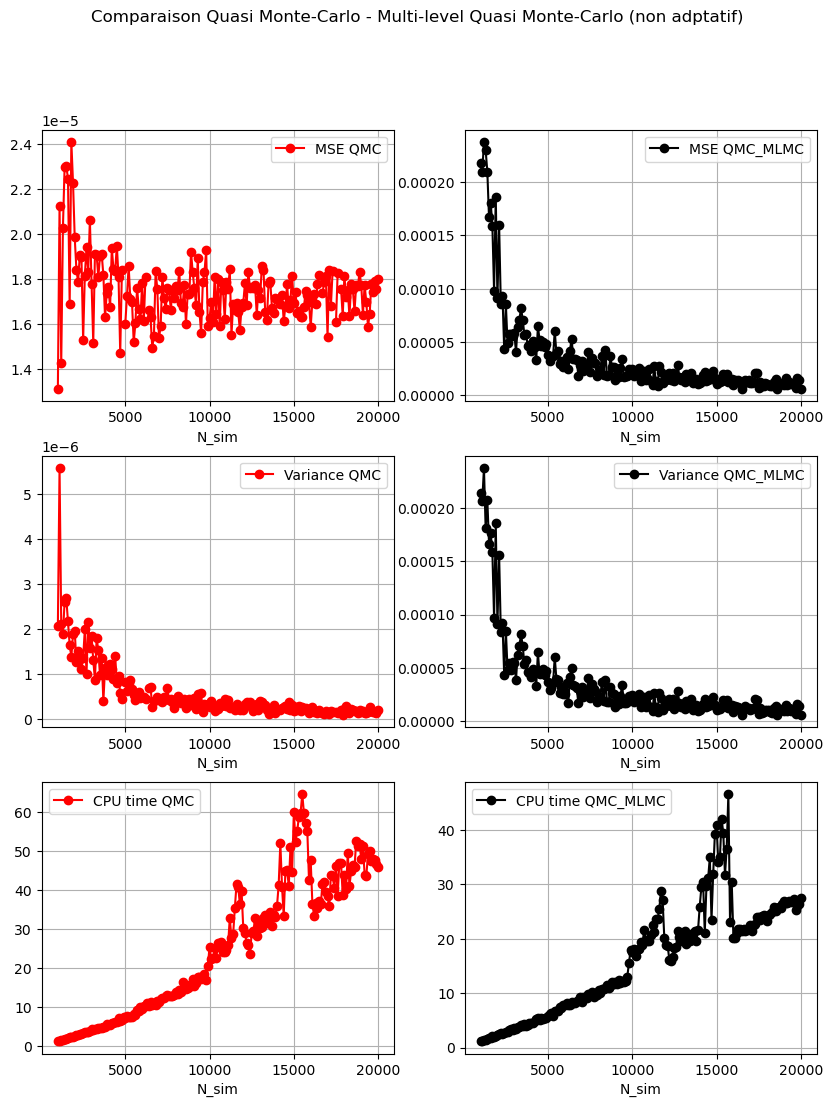

In [ ]:
def plot_perf(ax, perf_mc, perf_mlmc, title):
    ax[0].plot(Nsim_loop_cmp, perf_mc, label = f'{title} QMC', marker = 'o', color='red')
    ax[0].grid('on')
    ax[0].legend(loc='best')
    ax[0].set_xlabel("N_sim")
    
    ax[1].plot(Nsim_loop_cmp, perf_mlmc, label = f'{title} QMC_MLMC', marker = 'o', color='black')
    ax[1].grid('on')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("N_sim")

fig, axs = plt.subplots(3, 2, figsize=(10, 12))

plot_perf(axs[0], MSE_QMC_cmp, MSE_QMC_MLMC_cmp, 'MSE')
plot_perf(axs[1], variances_QMC_Nsim_cmp, variances_QMC_MLMC_Nsim_cmp, 'Variance')
plot_perf(axs[2], mean_cpu_QMC_Nsim_cmp, mean_cpu_QMC_MLMC_Nsim_cmp, 'CPU time')

plt.suptitle(f'Comparaison Quasi Monte-Carlo - Multi-level Quasi Monte-Carlo (non adptatif)\n')
plt.show()

# Comparaison MSE/Variance/CPU entre QMC et QMC_MLMC_adpt (avec paramètres optimaux)

In [ ]:
MSE_QMC_MLMC_adpt_eps_cmp = []
MSE_QMC_eps_cmp = []

var_QMC_MLMC_adpt_eps_cmp = []
var_QMC_eps_cmp = []

cpu_QMC_MLMC_adpt_eps_cmp = []
cpu_QMC_eps_cmp = []

n_estimators = 30

epsilons = np.linspace(1e-1, 3e-4, 30)
for i in tqdm(range(len(epsilons))):
    eps = epsilons[i]
    variance_ad, mean_C_estimated_ad, mean_cpu_time_ad, estimators_ad = variance_cpu_qmc_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1)
    Mse_ad = np.mean([(x-true_C)**2 for x in estimators_ad])
    MSE_QMC_MLMC_adpt_eps_cmp.append(Mse_ad)
    var_QMC_MLMC_adpt_eps_cmp.append(variance_ad)
    cpu_QMC_MLMC_adpt_eps_cmp.append(mean_cpu_time_ad)
    
    Nsim = np.sum(Nls_eps[i])
    variance_qmc, mean_C_estimated_qmc, mean_cpu_time_qmc, estimators_qmc = variance_cpu_qmc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse_qmc = np.mean([(x-true_C)**2 for x in estimators_qmc])
    MSE_QMC_eps_cmp.append(Mse_qmc)
    var_QMC_eps_cmp.append(variance_qmc)
    cpu_QMC_eps_cmp.append(mean_cpu_time_qmc)

 63%|██████▎   | 19/30 [14:40<08:47, 47.99s/it]/tmp/ipykernel_191/3515591021.py:3: RuntimeWarning: divide by zero encountered in log
  Y = np.sqrt(-2*np.log(x[1]))*np.cos(2*np.pi*x[0])
 97%|█████████▋| 29/30 [23:51<01:09, 69.47s/it]

In [ ]:
def plot_perf(ax, perf_mc, perf_mlmc, title):
    ax[0].plot(epsilons[:-1], perf_mc, label = f'{title} QMC', marker = 'o', color='red')
    ax[0].grid('on')
    ax[0].legend(loc='best')
    ax[0].set_xlabel("N_sim")
    
    ax[1].plot(epsilons, perf_mlmc, label = f'{title} QMC_MLMC', marker = 'o', color='black')
    ax[1].grid('on')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("N_sim")

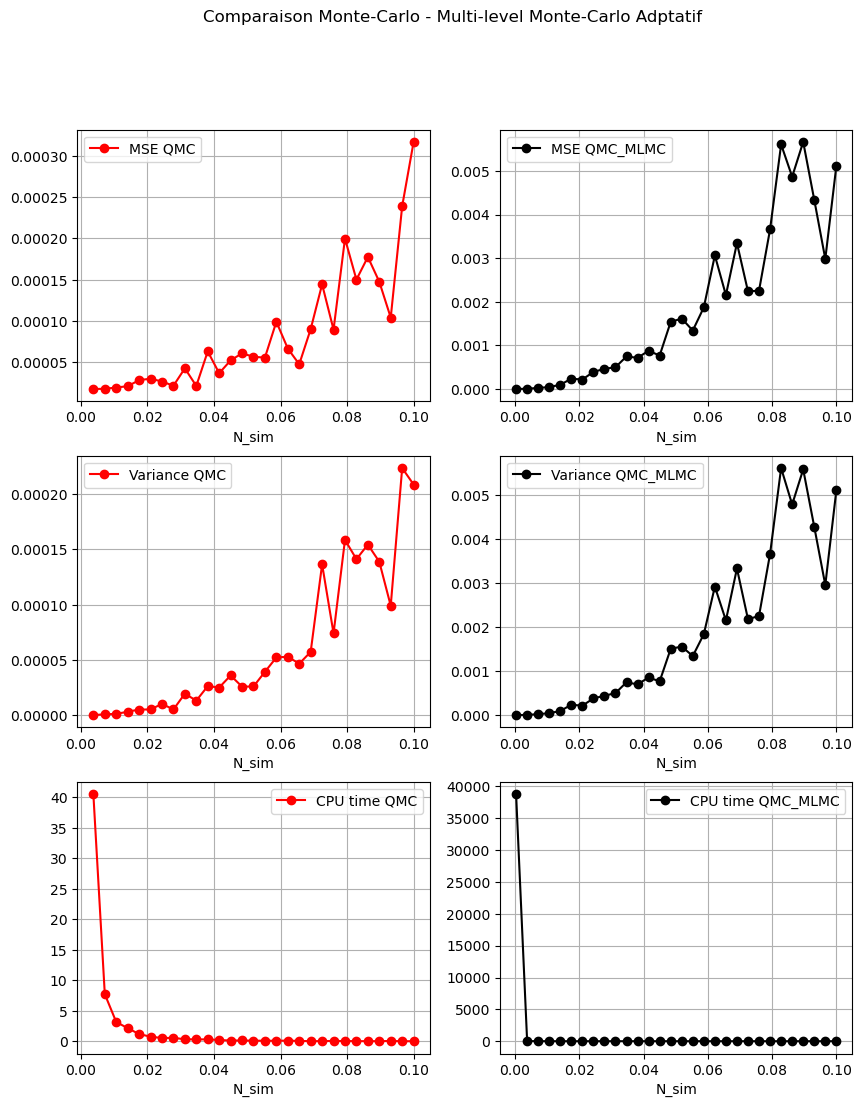

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

plot_perf(axs[0], MSE_QMC_eps_cmp, MSE_QMC_MLMC_adpt_eps_cmp, 'MSE')
plot_perf(axs[1], var_QMC_eps_cmp, var_QMC_MLMC_adpt_eps_cmp, 'Variance')
plot_perf(axs[2], cpu_QMC_eps_cmp, cpu_QMC_MLMC_adpt_eps_cmp, 'CPU time')

plt.suptitle(f'Comparaison Monte-Carlo - Multi-level Monte-Carlo Adptatif\n')
plt.show()